In [1]:
#!pip install -U torch torchvision torchtext torchdata pytest torchsummary portalocker

### Import libraries

In [2]:
from data_chatbot import questions_answers, load_df, toTensor, show_lengths, tokenize_questions,tokenize_answers
from data_chatbot import pretrained_w2v, prepare_text
from models_chatbot import Seq2Seq
from vocab_chatbot import Vocab


from train_chatbot import pretrain, train
from apply_chatbot import apply_chatbot



C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org

### Tests

In [3]:
!python -m pytest -vv tests_chatbot.py

============================= test session starts =============================
platform win32 -- Python 3.7.3, pytest-4.3.1, py-1.8.0, pluggy-0.9.0 -- C:\Users\Adam\Anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Adam\Desktop\Udacity\DL-Generative-Chatbot, inifile:
plugins: remotedata-0.3.1, openfiles-0.3.2, doctestplus-0.3.0, arraydiff-0.3
collecting ... collected 2 items

tests_chatbot.py::test_seq2seq_forward FAILED                            [ 50%]
tests_chatbot.py::test_heteroDataLoader FAILED                           [100%]

================================== FAILURES ===================================
____________________________ test_seq2seq_forward _____________________________

question = tensor([1, 2, 3]), answer = tensor([2, 4, 6])
vocab_source = <vocab_chatbot.Vocab object at 0x000002084C4172E8>
vocab_target = <vocab_chatbot.Vocab object at 0x000002084C4173C8>

    def test_seq2seq_forward(question, answer, vocab_source, vocab_target):
        # test trai

### Raw data

In [4]:
# source_name = "poc"
source_name = "squad1"

In [5]:
df_train = load_df(source_name=source_name)
df_train.head()

,Question,Answer
0,To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous
1,What is in front of the Notre Dame Main Building?,a copper statue of Christ
2,The Basilica of the Sacred heart at Notre Dame...,the Main Building
3,What is the Grotto at Notre Dame?,a Marian place of prayer and reflection
4,What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary


In [6]:
len(df_train)

87599

### Tokenized sentences

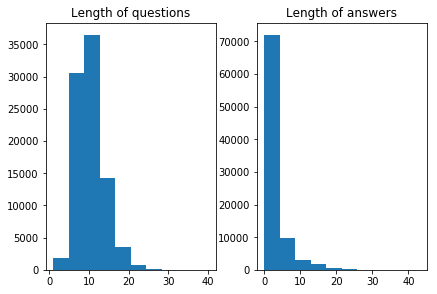

In [7]:
questions_train_raw, questions_valid_raw, answers_train_raw, answers_valid_raw = questions_answers(source_name=source_name)
show_lengths(questions_train_raw, questions_valid_raw, answers_train_raw, answers_valid_raw)

### Filter data

In [8]:
# a desicion has to be made between the next and the after next block

In [9]:
# temp = [pair for pair in zip(questions_train_raw, answers_train_raw) if len(pair[1])>3]
# questions_train_filt, answers_train_filt = map(list, zip(*temp))
# temp = [pair for pair in zip(questions_valid_raw, answers_valid_raw) if len(pair[1])>3]
# questions_valid_filt, answers_valid_filt = map(list, zip(*temp))
# print(f"{len(questions_train_filt)} training questions and {len(questions_valid_filt)} valid questions remain.")

In [10]:
questions_train_filt = questions_train_raw[:5000]
questions_valid_filt = questions_valid_raw[4501:5000]
answers_train_filt = answers_train_raw[:5000]
answers_valid_filt = answers_valid_raw[4501:5000]

### Create vocabularies

In [11]:
vQ = Vocab("Questions")
for sequence in [["<SOS>", "<EOS>"]] + questions_train_filt + questions_valid_filt:
    for token in sequence:
        vQ.indexWord(token)
vA = Vocab("Answers")
for sequence in [["<SOS>", "<EOS>"]] + answers_train_filt + answers_valid_filt:
    for token in sequence:
        vA.indexWord(token)
print(f"The source vocabulary contains {len(vQ.word2index)} and the target vocabulary contains {len(vA.word2index)} words.")

The source vocabulary contains 4797 and the target vocabulary contains 4564 words.


### Create vectors

In [12]:
questions_train = tokenize_questions(questions_train_filt, vQ)
answers_train = tokenize_answers(answers_train_filt, vA)
questions_valid = tokenize_questions(questions_valid_filt, vQ)
answers_valid = tokenize_answers(answers_valid_filt, vA)

### Create model

In [13]:
input_size = len(vQ.word2index)
hidden_size = 124
output_size = len(vA.word2index) 

dropout_E=0.0
dropout_D=0.0
teacher_forcing_ratio=0.0


model = Seq2Seq(input_size, hidden_size, output_size)

### Utilize pretrained embeddings

In [14]:
# w2v = pretrained_w2v(init=False)
# model = pretrain(model, vQ, vA, w2v)

#### => most_similar is not working after adding vector in gensim

### Train model

In [19]:
epochs = 50
batch_size = 124
print_each = 5
lr = 0.01
weight_decay = 0
version = str(hidden_size)
train(epochs, batch_size, print_each, lr, model, version, questions_train, answers_train, vQ, vA)

Nothing to load at checkpoint: 'model_124.pt'
Computing on cpu.

epoch: 1/1 	train_loss: 6.042 	valid_loss 6.647
question: <SOS> who rank new york as the most walkabl larg us citi in 2015 <EOS> 
answer: walk score <EOS> 
prediction: the <EOS> <EOS>  



In [22]:
import torch
version = 124
model.load_state_dict(torch.load(f"model_{version}.pt", map_location=torch.device('cpu')))
print(f"Loading from checkpoint: 'model_{version}.pt'")


max_count = 0
for answer in answers_train:
    if len(answer) > max_count:
        max_count = len(answer)

model.eval()
string2stop = 'quit'
print(f"Type {string2stop} to finish the chat.\n")

    
while (True):
    question = input("> ")
    if question.strip() == string2stop:
        break
    
    apply_chatbot(model, tokenize_questions([prepare_text(question)],vQ)[0].view(-1,1), vQ, vA, max_count)

Loading from checkpoint: 'model_124.pt'
Type quit to finish the chat.

> who else?
<  the <EOS>

> why?
<  the <EOS>

> quit
